In [100]:
%matplotlib inline
from matplotlib import pyplot as plt 

import numpy as np
import pandas as pd

from pandas.plotting import scatter_matrix

from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import metrics

import joblib

# Load Data 

In [41]:
df_housing = pd.read_csv('../datasets/housing/housing.csv', encoding='utf8', sep=',')
print(df_housing.shape)
df_housing[:3]

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [42]:
# total_bedrooms has some na values

print(df_housing.info())
print("#" * 30)
print(df_housing.describe())
print("#" * 30)
print(df_housing['ocean_proximity'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
##############################
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   

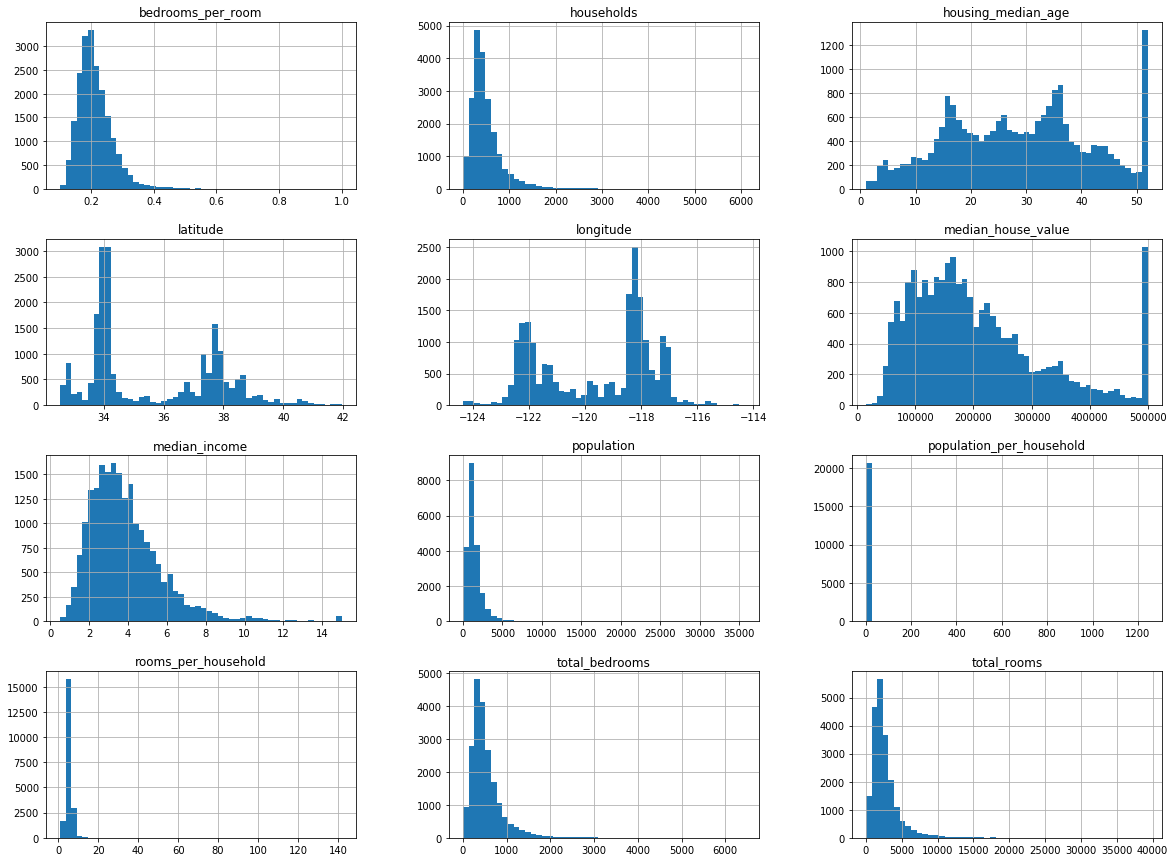

In [27]:
df_housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Split Data

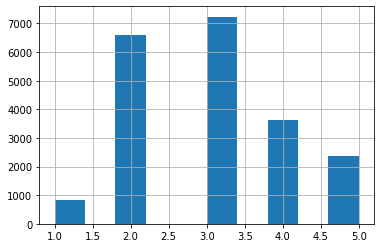

In [43]:
df_housing['income_cat'] = pd.cut(df_housing['median_income'], bins=[0.0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
df_housing['income_cat'].hist()
plt.show()

In [44]:
# Stratified shuffle split
split = model_selection.StratifiedShuffleSplit(
    n_splits=1, 
    test_size=0.2, 
    random_state=42
)
for train_idx, val_idx in split.split(df_housing, df_housing['income_cat']):
    df_train_strat = df_housing.loc[train_idx]
    df_val_strat = df_housing.loc[val_idx]
    break

# or random split
df_train_rand, df_val_rand = model_selection.train_test_split(df_housing, test_size=0.2, random_state=42)

# compare the propotions
def income_cat_proportions(df):
    return df["income_cat"].value_counts() / len(df)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df_housing),
    "Stratified": income_cat_proportions(df_val_strat),
    "Random": income_cat_proportions(df_val_rand),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [52]:
# seems like stratified split is better
df_train = df_train_strat.drop(columns=["income_cat"])
df_val = df_val_strat.drop(columns=["income_cat"])

X_train = df_train.drop("median_house_value", axis=1)
y_train = df_train['median_house_value'].copy()
print(X_train.shape, y_train.shape)

X_val = df_val.drop("median_house_value", axis=1)
y_val = df_val['median_house_value'].copy()
print(X_val.shape, y_val.shape)

(16512, 9) (16512,)
(4128, 9) (4128,)


# EDA

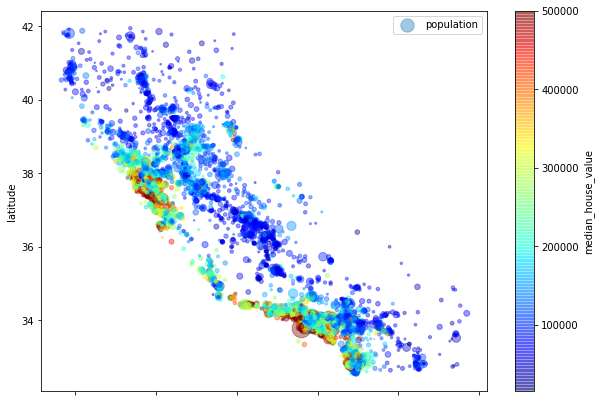

In [53]:
df_train.plot(
    kind="scatter", 
    x = "longitude", 
    y = "latitude", 
    alpha = 0.4,  # ???
    s = df_housing['population'] / 100,  # radius of circle
    label = "population",  
    figsize = (10, 7), 
    c = "median_house_value",  # color
    cmap = plt.get_cmap("jet"), 
    colorbar = True
)
plt.legend()
plt.show()

In [54]:
corr_matrix = df_train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [55]:
# attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "latitude"]
# scatter_matrix(df_train[attributes], figsize=(16, 9))
# plt.show()

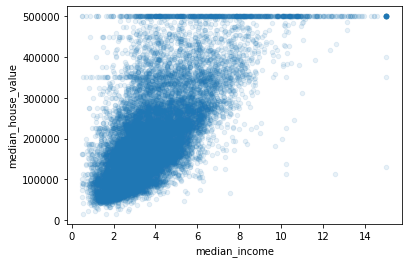

In [56]:
df_train.plot(
    kind="scatter", 
    x = "median_income", 
    y = "median_house_value", 
    alpha = 0.1
)
plt.show()

# Feature Engineering

In [57]:

def do_feature_engineering(df_X):
    # try some attribute combinations
    df_tmp = df_X.copy()
    df_tmp['rooms_per_household'] = df_tmp['total_rooms'] / df_tmp['households']
    df_tmp['bedrooms_per_room'] = df_tmp['total_bedrooms'] / df_tmp['total_rooms']
    df_tmp['population_per_household'] = df_tmp['population'] / df_tmp['households']
    
    cat_feats = ["ocean_proximity"]
    num_feats = [c for c in df_tmp.columns if c not in cat_feats]
    print("num_feats", num_feats)
    print("cat_feats: ", cat_feats)
    
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), 
        ("std_scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("onehot_encoder", OneHotEncoder()), 
    ])

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_feats), 
        ("cat", cat_pipeline, cat_feats), 
    ])
    
    return full_pipeline.fit_transform(df_tmp)

X_train_prepared = do_feature_engineering(X_train)
print(X_train_prepared.shape)
X_train_prepared[:3]

num_feats ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
cat_feats:  ['ocean_proximity']
(16512, 16)


array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452,  0.19380531,
        -0.08649871,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.94074539,
        -0.03353391,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516,  0.49916044,
        -0.09240499,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

# Modeling

In [101]:
lr = LinearRegression(n_jobs=-1)
decision_tree = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
svr = SVR(kernel="linear")
model = svr
model.fit(X_train_prepared, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [102]:
y_train_pred = model.predict(X_train_prepared)
print("rmse: ", np.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)))

X_val_prepared = do_feature_engineering(X_val)
y_val_pred = model.predict(X_val_prepared)
print("rmse: ", np.sqrt(metrics.mean_squared_error(y_true=y_val, y_pred=y_val_pred)))

rmse:  110981.41510737606
num_feats ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
cat_feats:  ['ocean_proximity']
rmse:  109277.42710931168


In [103]:
scores = model_selection.cross_val_score(
    model, 
    X_train_prepared, 
    y_train, 
    scoring="neg_mean_squared_error", 
    cv=10
)
print("rmse: %f +- %f" % (np.sqrt(-scores).mean(), np.sqrt(-scores).std()))

rmse: 111711.148883 +- 2754.305305


In [99]:
# joblib.dump(model, "model_tmp.pkl")
# model  =joblib.load("model_tmp.pkl")

In [104]:
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]}, 
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

grid_search = model_selection.GridSearchCV(
    rf, param_grid, cv=5, 
    scoring="neg_mean_squared_error", 
    return_train_score=True
)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
       

In [106]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [107]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [109]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64458.703211119835 {'max_features': 2, 'n_estimators': 3}
55692.08685354938 {'max_features': 2, 'n_estimators': 10}
53128.69899651111 {'max_features': 2, 'n_estimators': 30}
61141.87707556726 {'max_features': 4, 'n_estimators': 3}
52459.84256673868 {'max_features': 4, 'n_estimators': 10}
50287.319566187136 {'max_features': 4, 'n_estimators': 30}
57813.29696948525 {'max_features': 6, 'n_estimators': 3}
51708.493147975496 {'max_features': 6, 'n_estimators': 10}
49845.89429651649 {'max_features': 6, 'n_estimators': 30}
58767.52483928829 {'max_features': 8, 'n_estimators': 3}
51621.596295681615 {'max_features': 8, 'n_estimators': 10}
49708.10725415681 {'max_features': 8, 'n_estimators': 30}
62286.530201939124 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54353.316248363495 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
57962.5948974663 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52039.04912577611 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [114]:
feature_importances= grid_search.best_estimator_.feature_importances_
feature_importances

array([6.76176095e-02, 5.91026478e-02, 4.28232848e-02, 1.60259053e-02,
       1.46546897e-02, 1.55615897e-02, 1.46071863e-02, 3.72603755e-01,
       5.06891867e-02, 6.12268291e-02, 1.13515409e-01, 7.01392026e-03,
       1.59145641e-01, 7.57140630e-05, 1.85167609e-03, 3.48495547e-03])

In [120]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"].named_steps["onehot_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = [c for c in X_train.columns if c not in ["ocean_proximity"]]  + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3726037550029671, 'median_income'),
 (0.1591456409796966, 'NEAR OCEAN'),
 (0.11351540922091989, 'ISLAND'),
 (0.06761760950204279, 'longitude'),
 (0.06122682905969682, 'INLAND'),
 (0.05910264780002197, 'latitude'),
 (0.050689186697425656, '<1H OCEAN'),
 (0.04282328484209212, 'housing_median_age'),
 (0.016025905343031947, 'total_rooms'),
 (0.015561589661685757, 'population'),
 (0.014654689653403379, 'total_bedrooms'),
 (0.014607186349783353, 'households'),
 (0.007013920263280008, 'NEAR BAY')]

In [124]:
y_val_pred = grid_search.best_estimator_.predict(X_val_prepared)
print("rmse: ", np.sqrt(metrics.mean_squared_error(y_true=y_val, y_pred=y_val_pred)))

rmse:  70019.27642045745


In [126]:
from scipy import stats

confidence = 0.95
squared_errors = (y_val_pred - y_val) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([67978.0737309, 72002.6362901])

In [127]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(67978.07373090449, 72002.636290101)

In [128]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(67978.68135599174, 72002.06262315961)